In [1]:
import numpy as np
import os; os.chdir("..")
import warnings
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

from vantage6.algorithm.tools.mock_client import MockAlgorithmClient
warnings.filterwarnings("ignore")

In [2]:
data_dir = os.path.join(os.getcwd(), "./vtg_km_he", "local")
data_path = os.path.join(data_dir, "data_test.csv")
df = pd.read_csv(data_path)
df

,0,1,2,3,4,C,T
0,-0.04518,-0.15407,-0.38322,-0.16410,0.18149,1.0,1.0
1,0.13559,0.43563,0.01046,-0.06103,0.22061,0.0,25.0
2,0.25824,0.25285,0.33758,0.23398,-0.12381,0.0,53.0
3,-0.36326,-0.14392,-0.30458,0.25528,0.39562,1.0,12.0
4,-0.42186,-0.25667,0.23794,-0.27736,0.12835,1.0,31.0
...,...,...,...,...,...,...,...
195,-0.15622,0.36398,0.18487,-0.32684,-0.07903,1.0,52.0
196,0.33239,0.37361,0.30750,0.02121,-0.33076,1.0,28.0
197,0.35748,-0.20104,-0.41990,0.06762,-0.27252,1.0,23.0
198,-0.43103,0.13096,0.35723,0.44050,0.05443,1.0,6.0


In [3]:
# Partitioning data
# data_dir = os.path.join(os.getcwd(), "vtg_km_he", "local")
# data_path = os.path.join(data_dir, "data_test.csv")
# data1_path = os.path.join(data_dir, "data1.csv")
# data2_path = os.path.join(data_dir, "data2.csv")
# print(data2_path)

# df = pd.read_csv(data_path)
# df["COHORT_DEFINITION_ID"] = np.random.randint(low=0, high=2, size=(df.shape[0],))
# df = df.rename(columns={'T':'TIME_AT_RISK','C':'MORTALITY_FLAG'}, inplace=False) 
# df = df.sample(frac=1) # Shuffle data
# display(df)


# df[0:int(len(df)/2)].to_csv(data1_path)
# df[int(len(df)/2):].to_csv(data2_path)

In [4]:
JAMES_DATA_RUN = True

if JAMES_DATA_RUN:
    dataset_1 = {"database": "../Synthetic_outcomes/Synthetic_outcomes_high_prev.csv", "db_type": "csv"}
    dataset_2 = {"database": "../Synthetic_outcomes/Synthetic_outcomes_low_prev.csv", "db_type": "csv"}
else:
    dataset_1 = {"database": "./vtg_km_he/local/data1.csv", "db_type": "csv"}
    dataset_2 = {"database": "./vtg_km_he/local/data2.csv", "db_type": "csv"}

org_ids = ids = [0, 1]
display(dataset_1, dataset_2)

{'database': '../Synthetic_outcomes/Synthetic_outcomes_high_prev.csv',
 'db_type': 'csv'}

{'database': '../Synthetic_outcomes/Synthetic_outcomes_low_prev.csv',
 'db_type': 'csv'}

In [5]:
client = MockAlgorithmClient(
    datasets = [[dataset_1], [dataset_2]],
    organization_ids=org_ids,
    module="vtg_km_he"
)

In [6]:
organizations = client.organization.list()
org_ids = ids = [organization["id"] for organization in organizations]

In [7]:
cohort_ids = [1029, 1030, 1031, 1032, 1033, 1034, 1035]

cohort_id = 1030
def execute_km_master_task(
        aggregator_node: str | int,
        cohort_id: str | int,
        time_column_name: str = 'TIME_AT_RISK',
        censor_column_name: str = 'MORTALITY_FLAG'):
    task = client.task.create(
        input_={
            'master': 1,
            'method': 'master',
            'kwargs': {
                'time_column': time_column_name,
                'censor_column': censor_column_name,
                'cohort_id': cohort_id}
        },
        organizations=[org_ids[0]]
    )
    results = client.result.get(task.get("id"))

    results['kaplanMeier'] = pd.read_json(results['kaplanMeier'])
    results['local_event_tables'] = [pd.read_json(value) for value in results['local_event_tables']]
    df_events = results['kaplanMeier']
    try:
        results['kaplanMeier'].to_csv('results.csv')
    except:
        results['kaplanMeierLR'].to_csv('results_lr.csv')
        results['kaplanMeierHR'].to_csv('results_hr.csv')
    return results


info > Collecting information on participating organizations
info > Sending task to organizations [0, 1]
info > Collecting unique event times
info > Sending task to organizations [0, 1]
info > Waiting for results
info > Mocking waiting for results
info > Results obtained for get_unique_event_times!
info > Collected unique event times for 2 organization(s)
info > Collecting local event tables
info > Sending task to organizations [0, 1]
info > Sample size 7708
info > Overall number of patients: 7708
info > Number of patients in the cohort #1029: 3854
info > Sample size 7708
info > Overall number of patients: 7708
info > Number of patients in the cohort #1029: 3854
info > Waiting for results
info > Mocking waiting for results
info > Results obtained for get_km_event_table!
info > Collected local event tables for 2 organization(s)
info > Aggregating event tables
info > Kaplan-Meier curve has been computed successfully
info > Collecting information on participating organizations
info > Send

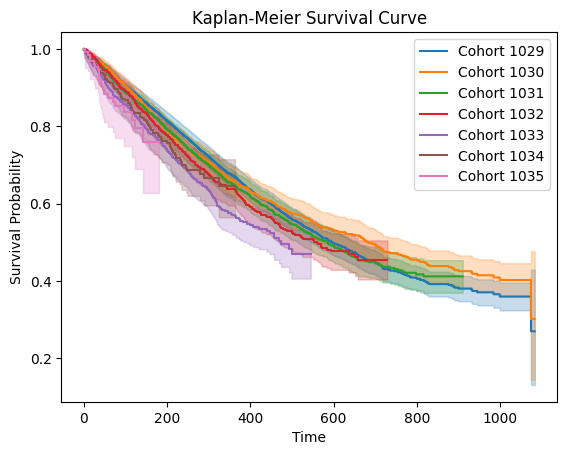

In [9]:
for cohort_id in cohort_ids:

    results = execute_km_master_task(
        aggregator_node=0,
        cohort_id=cohort_id,
        time_column_name='TIME_AT_RISK',
        censor_column_name='MORTALITY_FLAG')
    # Example data (replace this with your actual data)
    data = results['kaplanMeier']

    # Calculate 'AtRisk' from 'Total'
    data['AtRisk'] = data['Total'].cumsum()

    # Create a KaplanMeierFitter object
    kmf = KaplanMeierFitter()

    # Fit the data to KaplanMeierFitter
    kmf.fit(durations=data['TIME_AT_RISK'], event_observed=data['Deaths'], timeline=data['TIME_AT_RISK'])
    # Plot the Kaplan-Meier curve on the same plot
    kmf.plot(label=f'Cohort {cohort_id}')
   
# Add title and labels
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Add legend
plt.legend()

# Show the plot
plt.show()
